<a href="https://colab.research.google.com/github/pgeorgantopoulos/pinns/blob/main/pinn_vs_neuraloperator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
import matplotlib.pyplot as plt

In [143]:
t = torch.linspace(0,10,100)
t.requires_grad = True

def dxdt(t):
    """
    dx/dt = f(t) = a t
    """
    return -.9*t

f = torch.nn.Sequential(torch.nn.Linear(in_features=1, out_features=10),
                        torch.nn.Sigmoid(),
                        torch.nn.Linear(in_features=10, out_features=1)
                        )

# train f for 10 epoch
optimizer = torch.optim.SGD(f.parameters(), lr=.001)
keep_loss = torch.zeros(10)
for k in range(10):
    optimizer.zero_grad()
    loss = torch.tensor([0.])
    for t_i in t:
        f_i = f(t_i.unsqueeze(0))
        dxdt_i = torch.autograd.grad(f_i, t_i, create_graph=True)[0]
        loss += (dxdt(t_i.unsqueeze(0)) - dxdt_i)**2 + (f(t[0].unsqueeze(0)) - torch.tensor([1]))**2
    loss.backward()
    optimizer.step()
    keep_loss[k] = loss.item()


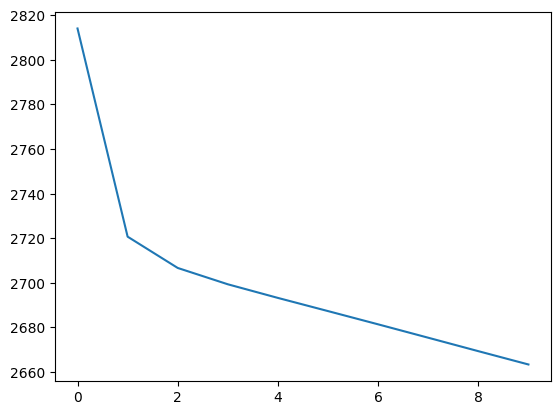

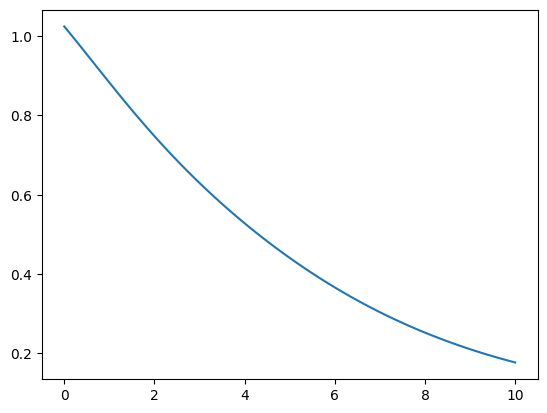

In [144]:
plt.plot(keep_loss)
plt.figure()
plt.plot(t.detach().numpy(), f(t.unsqueeze(1)).detach().numpy(), )